In [1]:
################################ config #################################

#!/usr/bin/env python3

from datetime import datetime
from astropy.io import fits
import numpy as np
import glob
import tqdm
from progressbar import progressbar

# parameters
i = 0

stride = 4
win_size_large = 16
win_size_small = 4
clusters = 3

# For testing

files = glob.glob('../MDI_synoptic/MDI_maps/*.fits') #!!!!!!!!! first add map path
np.sort(files)

# Get data shape
img_shape = fits.open(files[0])[0].data.shape

# Pre-allocate storage
all_data = np.empty((len(files), img_shape[1], img_shape[0]),
                    dtype=np.float32)
print('shape of all_data', all_data.shape)

shape of all_data (165, 3600, 1080)


In [2]:
################################ read .fits file #################################

p = progressbar
for i, f in p(enumerate(files)):
    fd = fits.open(f)[0]

    # Original times are TAI (international atomic time) currently not needed
    fmt = r'%Y.%m.%d_%H:%M:%S_%Z'
    t0 = datetime.strptime(fd.header['T_START'][0:-4]+'_UTC', fmt)
    t1 = datetime.strptime(fd.header['T_STOP'][0:-4]+'_UTC', fmt)
    t0 = np.datetime64(t0)
    t1 = np.datetime64(t1)

    # Assume t0 and t1 are at the boundaries of the image
    fractional_times = t0 + (t1-t0) * \
        np.linspace(0.5, img_shape[1]-0.5, img_shape[1])/img_shape[1]

    all_data[i] = fd.data.T[::-1]

print(all_data.shape)

| |    #                                            | 164 Elapsed Time: 0:00:20


(165, 3600, 1080)


In [10]:
################################ dimensional reduction prep (e.g., remove nan) #################################

import skimage.measure

def norm_ah(X):
    num = X.shape[1]
    out = np.zeros(X.shape)
    for i in range(num):
        dis = X[:,i].max() - X[:,i].min()
        out[:,i] = (X[:,i] - X[:,i].min())/dis
        
    #ipdb.set_trace()
    
    return out



clu = []
coord = []

for m in p(range(win_size_large, all_data.shape[1]-win_size_large, stride)):
    for n in range(win_size_large+90, 
                   all_data.shape[2]-win_size_large-180, 
                   stride):
        t = norm_ah(all_data[i, 
                     m-win_size_large:m+win_size_large, 
                     n-win_size_large:n+win_size_large]**2)
        coord_t = [m, n]
        
        t1 = skimage.measure.block_reduce(
                t, 
                (win_size_small, win_size_small), 
                np.nanmean).reshape(-1,1)
        
        clu.append(t1.squeeze())
        coord.append(coord_t)
    
print(np.array(clu).shape)
X = np.array(clu)
coords = np.array(coord)


100% (892 of 892) |######################| Elapsed Time: 0:01:14 Time:  0:01:14


(173940, 64)


In [16]:
################################ dimensional reduction (PCA) #################################

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_t = PCA(n_components=5).fit_transform(X)

print(X_t.shape)
plt.plot(X_t[:,0], X_t[:,1], '*')
plt.show()

(173940, 5)


In [ ]:
################################ dimensional reduction (T-SNE) #################################

# better not to run it, very time consuming
from sklearn.manifold import TSNE

X_t = TSNE(n_components=2).fit_transform(X)

print(X_t.shape)
plt.plot(X_t[:,0], X_t[:,1], 100)

In [ ]:
###################################### method (DBSCAN) ##########################
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=100).fit(X_t)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_        
    
plt.hist(labels, 100)
print(labels)

In [17]:
###################################### method (Kmeans) ##########################

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5).fit(X_t)
labels = kmeans.predict(X_t)

plt.hist(labels, 100)



(array([47446.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 30616.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 33010.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 30241.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 32627.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 

<IPython.core.display.Javascript object>


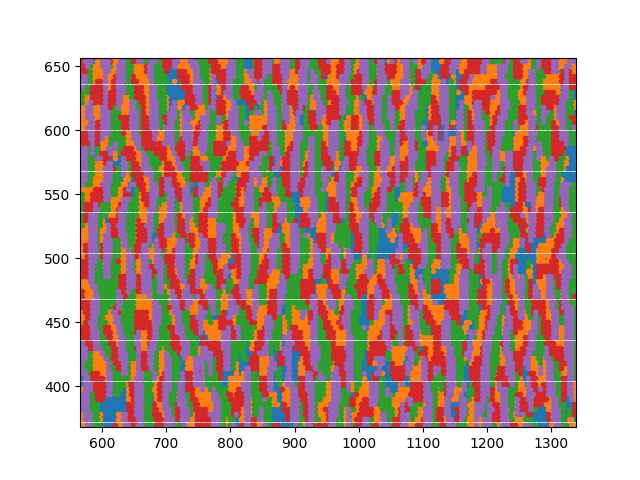

In [19]:
###################################### display ##########################

%matplotlib notebook
for i in range(5):
    idx = np.where(labels==i)[0]
    plt.plot(coords[idx, 0], coords[idx, 1], '.')
    
plt.show()
